<a href="https://colab.research.google.com/github/Leila828/instadeep_labs/blob/master/detection_tuberculose_pulmonaire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/AI

/content/drive/My Drive/AI


In [ ]:
ls

 AAKRKIZP.png        CGBUGUQW.png   LPFSZWIK.png     tb_sub.csv   testData1.csv
'CGBUGUQW (1).png'   dt500DA@       models/          test/        train/
'CGBUGUQW (2).png'   fullSize/      sampleTest.csv   Test.csv     Train.csv


In [ ]:
!unzip images_800px.zip

In [ ]:
ls

stest/  train/  Train.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.preprocessing import  image
from PIL import  Image
from keras.utils import to_categorical
from sklearn.model_selection import  train_test_split

%matplotlib inline

In [ ]:
train_df = pd.read_csv("Train.csv")

In [ ]:
train_df.head()

,filename,ID,LABEL
0,train/VTYNBFTO.png,VTYNBFTO,1
1,train/GVVXXDOZ.png,GVVXXDOZ,0
2,train/PMRSQLXN.png,PMRSQLXN,0
3,train/JXISWDUU.png,JXISWDUU,1
4,train/JVWMAACC.png,JVWMAACC,1


In [ ]:
len(train_df)

718

In [ ]:
train_image = []

for i in tqdm(range(train_df.shape[0])):
  img =image.load_img(train_df["filename"][i], target_size=(28,28,3))
  img = image.img_to_array(img)
  img = img/255
  train_image.append(img)
x = np.array(train_image)  

100%|██████████| 718/718 [03:47<00:00,  3.16it/s]


In [ ]:
y = train_df["LABEL"].values
y = to_categorical(y)


In [ ]:
x

train/ITGNQUPQ.png


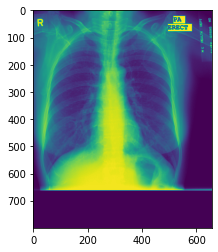

In [ ]:
img_num = 700
img = plt.imread(train_df["filename"][img_num])
plt.imshow(img)
print(train_df["filename"][img_num])

In [ ]:
test_df = pd.read_csv("Test.csv")

test/ZPPGWFUO.png


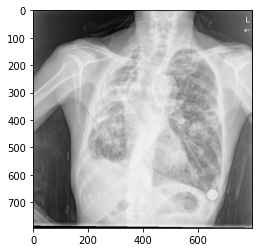

In [ ]:
img_num = 80
img = plt.imread(test_df["filename"][img_num])
plt.imshow(img)
print(test_df["filename"][img_num])


In [ ]:
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten,Conv2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import InceptionV3, VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED
               )
tf.random.set_seed(SEED)

In [ ]:
ls

test/  Test.csv  train/  Train.csv


In [ ]:

train_data = pd.read_csv('Train.csv')
test_data = pd.read_csv('Test.csv')
train_path = 'train/'
test_path = 'test/'

In [ ]:


# train
train_names = train_data.ID.values
train_labels = np.asarray(train_data['LABEL'].values)
train_dict = {'filepath': train_path + train_names + '.png', 'LABEL': train_labels}
train = pd.DataFrame(data=train_dict)
train['ID'] = train_data['ID']
train['LABEL'] = train.LABEL.apply(lambda x: 'Positive' if x == 1 else 'Normal')

# test
test_names = test_data.ID.values
test_dict = {'filepath': test_path + test_names + '.png'}
test = pd.DataFrame(data=test_dict)
test['ID'] = test_data['ID']

In [ ]:
train.shape, test.shape

((718, 3), (82, 2))

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


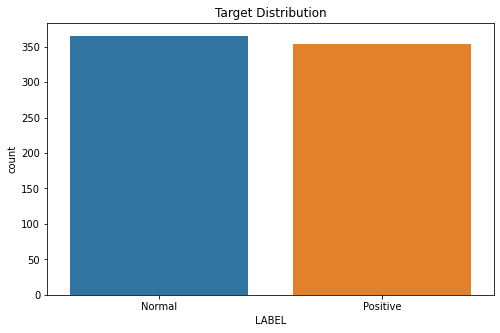

In [ ]:

f, ax = plt.subplots(1,1, figsize=(8,5))
sns.countplot(train['LABEL'],order = train['LABEL'].value_counts().index)
plt.title("Target Distribution")
plt.show()

In [ ]:

train.LABEL.value_counts()/len(train)

Normal      0.508357
Positive    0.491643
Name: LABEL, dtype: float64

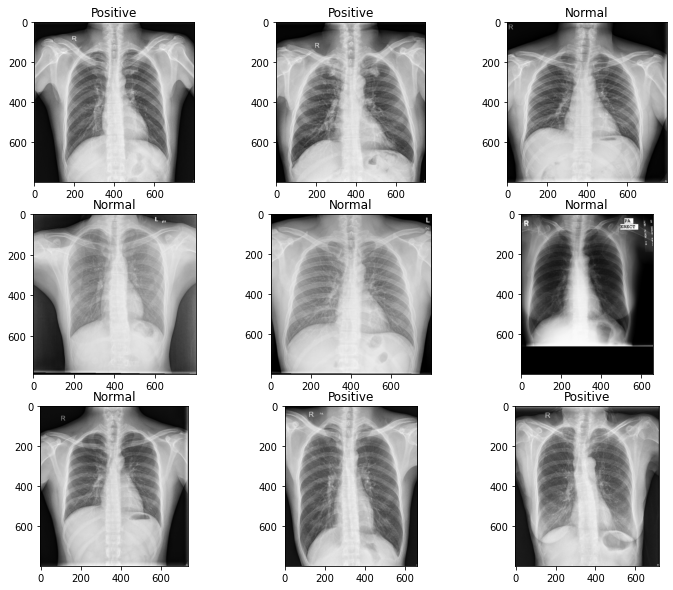

In [ ]:

nrows = 3
rands = np.random.randint(train.shape[0], size=nrows**2)
fig = plt.figure(figsize=(12,10))

for i in range(nrows**2):
    img = cv2.imread(train.loc[rands[i], 'filepath'])
    ax = plt.subplot(nrows, nrows, i+1)
    plt.imshow(img)
    plt.title(train.loc[rands[i], 'LABEL'])
plt.show()

In [ ]:

#We have 718 training samples and i will use 80% train and 20% validation  
df_train = train[:575:]
df_val = train[575:]
print(df_train.LABEL.value_counts())
print(df_val.LABEL.value_counts())

Normal      295
Positive    280
Name: LABEL, dtype: int64
Positive    73
Normal      70
Name: LABEL, dtype: int64


In [ ]:
#data generators
batch_size = 32  
image_size = (224, 224)
learning_rate = 0.0001

train_steps = np.ceil(len(df_train) / batch_size)
val_steps = np.ceil(len(df_val) / batch_size )

classes = train.LABEL.unique().tolist()

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,horizontal_flip=True,
                             vertical_flip=True,shear_range=10,zoom_range=0.2,width_shift_range=0.1,
                             height_shift_range=0.1,channel_shift_range=10.)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_datagen.flow_from_dataframe(df_train,x_col='filepath', y_col='LABEL',
                                        target_size=image_size,classes=classes,
                                        batch_size=batch_size,
                                        class_mode='categorical', shuffle=True, seed=SEED)

val_ds = val_datagen.flow_from_dataframe(df_val,x_col='filepath', y_col='LABEL',
                                        target_size=image_size,classes=classes,
                                        batch_size=batch_size,
                                        class_mode='categorical', shuffle=False, seed=SEED)

test_ds = val_datagen.flow_from_dataframe(test, x_col='filepath',target_size=image_size, class_mode=None,
                                          shuffle=False,batch_size=batch_size)#set shuffle=False for test dataset not

Found 575 validated image filenames belonging to 2 classes.
Found 143 validated image filenames belonging to 2 classes.
Found 82 validated image filenames.


In [ ]:
#we will use transfer learning from VGG16 model

def BuildModel (pretrained=VGG16):

    base_model = pretrained(include_top=False, weights='imagenet', input_shape=(224, 224,3)) #include_top=False to remove the last layer 

    for layer in base_model.layers:
        layer.trainable = False   #freeze trainable layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    x = Dense(3072, activation='relu', )(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    output = Dense(2, activation='softmax')(x) 
    
    model = Model(base_model.input, output)
    
    return model

In [ ]:
model = BuildModel()

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
#compile model
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['AUC'])

In [ ]:
#callbacks
import os
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
chkpt_path = os.path.join("AI/models/", f"tb_model.h5", )
checkpoint = ModelCheckpoint(chkpt_path, monitor='val_loss',mode='auto', verbose=1, save_best_only=True,)

In [ ]:
history = model.fit(train_ds, epochs=15,steps_per_epoch=train_steps, callbacks=[earlystop, checkpoint],
                    verbose=1, shuffle=False,validation_data=(val_ds), validation_steps= val_steps)

In [ ]:
#AUC
y_pred = model.predict(val_ds, verbose=1)[:, 1] 
fpr, tpr, thresholds = roc_curve(val_ds.classes, y_pred)
auc = auc(fpr, tpr)
auc

5/5 [==============================] - 59s 12s/step


0.8632093933463795

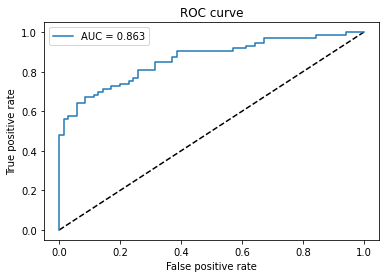

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


In [ ]:
predictions = model.predict(test_ds)[:, 1]

In [ ]:
submission = pd.DataFrame()
submission['ID'] = test['ID']
submission['LABEL'] = predictions
submission.to_csv('testData1.csv', index=False)

In [ ]:
submission = pd.DataFrame({'ID': test['ID'],
        'LABEL': predictions
    })
submission.to_csv('tb_sub.csv', index=False)

In [ ]:
submission

,ID,LABEL
0,GTWSHFYQ,0.227833
1,QTFSSMGD,0.021617
2,TBLBHSYT,0.768520
3,ZKETEOFG,0.829140
4,GKTPBGZP,0.689516
...,...,...
77,UHRZNUCQ,0.375557
78,RQZCAYRX,0.283302
79,KGOETYSK,0.141290
80,ZPPGWFUO,0.863583


In [ ]:
import time

t = time.time()

export_path = "/models/{}".format(int(t))

model.save(export_path, save_format='tf')

export_path

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /models/1603696433/assets


'/models/1603696433'

In [ ]:
export_path
reloaded = tf.keras.models.load_model(export_path)

In [ ]:
results_batch = model.predict(test_ds)
reloaded_results_batch  = reloaded.predict(test_ds)

In [ ]:
abs(results_batch - reloaded_results_batch).max()

0.0

In [ ]:
results_batch

array([[0.7721667 , 0.22783327],
       [0.97838324, 0.0216168 ],
       [0.23148006, 0.76851994],
       [0.17086044, 0.82913953],
       [0.31048393, 0.68951607],
       [0.02878263, 0.97121733],
       [0.06905008, 0.9309499 ],
       [0.52632207, 0.47367802],
       [0.8592732 , 0.14072682],
       [0.11288157, 0.88711846],
       [0.34842438, 0.6515757 ],
       [0.00199553, 0.9980045 ],
       [0.04612168, 0.9538783 ],
       [0.00369287, 0.99630713],
       [0.5677028 , 0.43229717],
       [0.14603937, 0.85396063],
       [0.08341897, 0.916581  ],
       [0.4371749 , 0.562825  ],
       [0.06814299, 0.93185693],
       [0.37498537, 0.6250146 ],
       [0.51363564, 0.48636433],
       [0.86557823, 0.1344217 ],
       [0.88126147, 0.11873852],
       [0.61394763, 0.38605246],
       [0.71355295, 0.28644702],
       [0.91170496, 0.08829512],
       [0.09674087, 0.9032591 ],
       [0.14473623, 0.8552637 ],
       [0.85253054, 0.14746948],
       [0.8427929 , 0.15720706],
       [0.

In [ ]:
reloaded_results_batch

array([[0.7721667 , 0.22783327],
       [0.97838324, 0.0216168 ],
       [0.23148006, 0.76851994],
       [0.17086044, 0.82913953],
       [0.31048393, 0.68951607],
       [0.02878263, 0.97121733],
       [0.06905008, 0.9309499 ],
       [0.52632207, 0.47367802],
       [0.8592732 , 0.14072682],
       [0.11288157, 0.88711846],
       [0.34842438, 0.6515757 ],
       [0.00199553, 0.9980045 ],
       [0.04612168, 0.9538783 ],
       [0.00369287, 0.99630713],
       [0.5677028 , 0.43229717],
       [0.14603937, 0.85396063],
       [0.08341897, 0.916581  ],
       [0.4371749 , 0.562825  ],
       [0.06814299, 0.93185693],
       [0.37498537, 0.6250146 ],
       [0.51363564, 0.48636433],
       [0.86557823, 0.1344217 ],
       [0.88126147, 0.11873852],
       [0.61394763, 0.38605246],
       [0.71355295, 0.28644702],
       [0.91170496, 0.08829512],
       [0.09674087, 0.9032591 ],
       [0.14473623, 0.8552637 ],
       [0.85253054, 0.14746948],
       [0.8427929 , 0.15720706],
       [0.